# Model Performance And Results

**Content**:
1. [Libraries](#libraries)
2. [Gridworld Creation](#gridworld)
3. [Functions](#funct)
4. [Uniform Dataset MLP Performance](#mlpuniform)
5. [Non-Uniform Dataset MLP Performance](#mlpnonuniform)
6. [Uniform Dataset LR Performance](#lruniform)
7. [Non-Uniform Dataset LR Performance](#lrnonuniform)
8. [Determination Of The Optimal Polynomial Linear Degree](#plrdegree)
9. [Uniform Dataset Polynomial LR Performance](#plruniform)
10. [Non-Uniform Dataset Polynomial LR Performance](#plrnonuniform)
11. [Visuals](#visuals)

## 1. Libraries <a id = "libraries"> 

In [14]:
import numpy as np
import random
import sys
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, validation_curve
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer

## 2. Gridworld Creation <a id = "gridworld">

In [15]:
def randPair(s,e):
    return np.random.randint(s,e), np.random.randint(s,e)

class BoardPiece:

    def __init__(self, name, code, pos):
        self.name = name #name of the piece
        self.code = code #an ASCII character to display on the board
        self.pos = pos #2-tuple e.g. (1,4)

class BoardMask:

    def __init__(self, name, mask, code):
        self.name = name
        self.mask = mask
        self.code = code

    def get_positions(self): #returns tuple of arrays
        return np.nonzero(self.mask)

def zip_positions2d(positions): #positions is tuple of two arrays
    x,y = positions
    return list(zip(x,y))

class GridBoard:

    def __init__(self, size=4):
        self.size = size #Board dimensions, e.g. 4 x 4
        self.components = {} #name : board piece
        self.masks = {}

    def addPiece(self, name, code, pos=(0,0)):
        newPiece = BoardPiece(name, code, pos)
        self.components[name] = newPiece

    #basically a set of boundary elements
    def addMask(self, name, mask, code):
        #mask is a 2D-numpy array with 1s where the boundary elements are
        newMask = BoardMask(name, mask, code)
        self.masks[name] = newMask

    def movePiece(self, name, pos):
        move = True
        for _, mask in self.masks.items():
            if pos in zip_positions2d(mask.get_positions()):
                move = False
        if move:
            self.components[name].pos = pos

    def delPiece(self, name):
        del self.components['name']

    def render(self):
        dtype = '<U2'
        displ_board = np.zeros((self.size, self.size), dtype=dtype)
        displ_board[:] = ' '

        for name, piece in self.components.items():
            displ_board[piece.pos] = piece.code

        for name, mask in self.masks.items():
            displ_board[mask.get_positions()] = mask.code

        return displ_board

    def render_np(self):
        num_pieces = len(self.components) + len(self.masks)
        displ_board = np.zeros((num_pieces, self.size, self.size), dtype=np.uint8)
        layer = 0
        for name, piece in self.components.items():
            pos = (layer,) + piece.pos
            displ_board[pos] = 1
            layer += 1

        for name, mask in self.masks.items():
            x,y = self.masks['boundary'].get_positions()
            z = np.repeat(layer,len(x))
            a = (z,x,y)
            displ_board[a] = 1
            layer += 1
        return displ_board

def addTuple(a,b):
    return tuple([sum(x) for x in zip(a,b)])

In [16]:
class Gridworld:

    def __init__(self, size=4, mode='static'):
        if size >= 4:
            self.board = GridBoard(size=size)
        else:
            print("Minimum board size is 4. Initialized to size 4.")
            self.board = GridBoard(size=4)

        #Add pieces, positions will be updated later
        self.board.addPiece('Player','P',(0,0))
        self.board.addPiece('Goal','+',(0,3))
        self.board.addPiece('Pit','-',(0,3))
        self.board.addPiece('Wall','W',(2,3))

        if mode == 'static':
            self.initGridStatic()
        elif mode == 'player':
            self.initGridPlayer()
        else:
            self.initGridRand()

    #Initialize stationary grid, all items are placed deterministically
    def initGridStatic(self):
        #Setup static pieces
        self.board.components['Player'].pos = randPair(0,self.board.size) #Row, Column
        self.board.components['Goal'].pos = (3,0)
        self.board.components['Pit'].pos = (3,1)
        self.board.components['Wall'].pos = (3,2)
        
        if (not self.validateBoard()):
            #print('Invalid grid. Rebuilding..')
            self.initGridStatic()


    #Check if board is initialized appropriately (no overlapping pieces)
    #also remove impossible-to-win boards
    def validateBoard(self):
        valid = True

        player = self.board.components['Player']
        goal = self.board.components['Goal']
        wall = self.board.components['Wall']
        pit = self.board.components['Pit']

        all_positions = [piece for name,piece in self.board.components.items()]
        all_positions = [player.pos, goal.pos, wall.pos, pit.pos]
        if len(all_positions) > len(set(all_positions)):
            return False

        corners = [(0,0),(0,self.board.size), (self.board.size,0), (self.board.size,self.board.size)]
        #if player is in corner, can it move? if goal is in corner, is it blocked?
        if player.pos in corners or goal.pos in corners:
            val_move_pl = [self.validateMove('Player', addpos) for addpos in [(0,1),(1,0),(-1,0),(0,-1)]]
            val_move_go = [self.validateMove('Goal', addpos) for addpos in [(0,1),(1,0),(-1,0),(0,-1)]]
            if 0 not in val_move_pl or 0 not in val_move_go:
                #print(self.display())
                #print("Invalid board. Re-initializing...")
                valid = False

        return valid

    #Initialize player in random location, but keep wall, goal and pit stationary
    def initGridPlayer(self):
        #height x width x depth (number of pieces)
        self.initGridStatic()
        #place player
        self.board.components['Player'].pos = randPair(0,self.board.size)

        if (not self.validateBoard()):
            #print('Invalid grid. Rebuilding..')
            self.initGridPlayer()

    #Initialize grid so that goal, pit, wall, player are all randomly placed
    def initGridRand(self):
        #height x width x depth (number of pieces)
        self.board.components['Player'].pos = randPair(0,self.board.size)
        self.board.components['Goal'].pos = randPair(0,self.board.size)
        self.board.components['Pit'].pos = randPair(0,self.board.size)
        self.board.components['Wall'].pos = randPair(0,self.board.size)

        if (not self.validateBoard()):
            #print('Invalid grid. Rebuilding..')
            self.initGridRand()

    def validateMove(self, piece, addpos=(0,0)):
        outcome = 0 #0 is valid, 1 invalid, 2 lost game
        pit = self.board.components['Pit'].pos
        wall = self.board.components['Wall'].pos
        new_pos = addTuple(self.board.components[piece].pos, addpos)
        if new_pos == wall:
            outcome = 1 #block move, player can't move to wall
        elif max(new_pos) > (self.board.size-1):    #if outside bounds of board
            outcome = 1
        elif min(new_pos) < 0: #if outside bounds
            outcome = 1
        elif new_pos == pit:
            outcome = 2

        return outcome

    def makeMove(self, action):
        #need to determine what object (if any) is in the new grid spot the player is moving to
        #actions in {u,d,l,r}
        def checkMove(addpos):
            if self.validateMove('Player', addpos) in [0,2]:
                new_pos = addTuple(self.board.components['Player'].pos, addpos)
                self.board.movePiece('Player', new_pos)

        if action == 'u': #up
            checkMove((-1,0))
        elif action == 'd': #down
            checkMove((1,0))
        elif action == 'l': #left
            checkMove((0,-1))
        elif action == 'r': #right
            checkMove((0,1))
        else:
            pass

    def reward(self):
        if (self.board.components['Player'].pos == self.board.components['Pit'].pos):
            return -10
        elif (self.board.components['Player'].pos == self.board.components['Goal'].pos):
            return 10
        else:
            return -1

    def display(self):
        return self.board.render()

In [17]:
action_set = {
    0: 'u',
    1: 'd',
    2: 'l',
    3: 'r',
}

## 3. Functions <a id = 'funct'> 

In [18]:
"""
from2dto1d:
    Args: 
        pos(tuple):2d position of the objects(Player, Wall, Goal, Pit) in the gridworld
    Return:
        return(integer): 1d position of the objects(Player, Wall, Goal, Pit)in the gridworld
""" 
def from2dto1d(pos):
    if pos == '(0, 0)':
        return 0
    if pos == '(0, 1)':
        return 1
    if pos == '(0, 2)':
        return 2
    if pos == '(0, 3)':
        return 3
    if pos == '(1, 0)':
        return 4
    if pos == '(1, 1)':
        return 5
    if pos == '(1, 2)':
        return 6
    if pos == '(1, 3)':
        return 7
    if pos == '(2, 0)':
        return 8
    if pos == '(2, 1)':
        return 9
    if pos == '(2, 2)':
        return 10
    if pos == '(2, 3)':
        return 11
    if pos == '(3, 0)':
        return 12
    if pos == '(3, 1)':
        return 13
    if pos == '(3, 2)':
        return 14
    if pos == '(3, 3)':
        return 15

In [19]:
def from1dto2d(pos):
    if pos == 0:
        return (0, 0)
    if pos == 1:
        return (0, 1)
    if pos == 2:
        return (0, 2)
    if pos == 3:
        return (0, 3)
    if pos == 4:
        return (1, 0)
    if pos == 5:
        return (1, 1)
    if pos == 6:
        return (1, 2)
    if pos == 7:
        return (1, 3)
    if pos == 8:
        return (2, 0)
    if pos == 9:
        return (2, 1)
    if pos == 10:
        return (2, 2)
    if pos == 11:
        return (2, 3)
    if pos == 12:
        return (3, 0)
    if pos == 13:
        return (3, 1)
    if pos == 14:
        return (3, 2)
    if pos == 15:
        return (3, 3)

In [20]:
"""
from_num_to_one_hot_encode:
    Args: 
        num(int): number from 0 to 15 representing the state of the objects(Player, Wall, Goal, Pit) in the gridworld
    Return:
        return(tuple): encoded binary code with the size of 16-bit 
"""
def from_num_to_one_hot_encode(num):
    en0,en1,en2,en3,en4,en5,en6,en7,en8,en9,en10,en11,en12,en13,en14,en15 = 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
    if num == 0:
        en0 = 1
    if num == 1:
        en1 = 1
    if num == 2:
        en2 = 1
    if num == 3:
        en3 = 1
    if num == 4:
        en4 = 1
    if num == 5:
        en5 = 1
    if num == 6:
        en6 = 1
    if num == 7:
        en7 = 1
    if num == 8:
        en8 = 1
    if num == 9:
        en9 = 1
    if num == 10:
        en10 = 1
    if num == 11:
        en11 = 1
    if num == 12:
        en12 = 1
    if num == 13:
        en13 = 1
    if num == 14:
        en14 = 1
    if num == 15:
        en15 = 1
    return en0,en1,en2,en3,en4,en5,en6,en7,en8,en9,en10,en11,en12,en13,en14,en15

In [21]:
def calculate_smape(actual, predicted) -> float:
    if not all([isinstance(actual, np.ndarray), 
                isinstance(predicted, np.ndarray)]):
        actual, predicted = np.array(actual),
        np.array(predicted)
  
    return round(
        np.mean(
            np.abs(predicted - actual) / 
            ((np.abs(predicted) + np.abs(actual))/2)
        )*100, 2
    )

In [22]:
score = make_scorer(calculate_smape)

In [23]:
def gridworld_test_model(model_b, mode='static', display=True):
    i = 0
    test_game = Gridworld(mode=mode)
    if display:
        print("Initial State:")
        print(test_game.display())
    status = 1
    j = 0
    while(status == 1): #A
        p_curr = from2dto1d((str(test_game.board.components['Player'].pos)))
        pi = from2dto1d((str(test_game.board.components['Pit'].pos)))
        g = from2dto1d((str(test_game.board.components['Goal'].pos)))
        w = from2dto1d((str(test_game.board.components['Wall'].pos)))

        q_value_next = []

        test_game.makeMove('u')
        p = from2dto1d((str(test_game.board.components['Player'].pos)))
        
        if p_curr != p:
            en0,en1,en2,en3,en4,en5,en6,en7,en8,en9,en10,en11,en12,en13,en14,en15 = from_num_to_one_hot_encode(p)
            reward = test_game.reward()
            q_value_next.append(model_b.predict([[p,pi,g,w]])[0])
            test_game.makeMove('d')
        else:
            q_value_next.append(-10)
        
        test_game.makeMove('d')
        p = from2dto1d((str(test_game.board.components['Player'].pos)))
        
        if p_curr != p:
            en0,en1,en2,en3,en4,en5,en6,en7,en8,en9,en10,en11,en12,en13,en14,en15 = from_num_to_one_hot_encode(p)
            reward = test_game.reward()
            q_value_next.append(model_b.predict([[p,pi,g,w]])[0])
            test_game.makeMove('u')
        else:
            q_value_next.append(-10)
        
        test_game.makeMove('l')
        p = from2dto1d((str(test_game.board.components['Player'].pos)))
        

        if p_curr != p:
            test_game.makeMove('r')
            en0,en1,en2,en3,en4,en5,en6,en7,en8,en9,en10,en11,en12,en13,en14,en15 = from_num_to_one_hot_encode(p)
            reward = test_game.reward()
            q_value_next.append(model_b.predict([[p,pi,g,w]])[0])
        else:
            q_value_next.append(-10)
        
        test_game.makeMove('r')
        p = from2dto1d((str(test_game.board.components['Player'].pos)))
        

        if p_curr != p:
            en0,en1,en2,en3,en4,en5,en6,en7,en8,en9,en10,en11,en12,en13,en14,en15 = from_num_to_one_hot_encode(p)
            reward = test_game.reward()
            q_value_next.append(model_b.predict([[p,pi,g,w]])[0])
            test_game.makeMove('l')
        else:
            q_value_next.append(-10)
        
#         print(q_value_next)
        
        
        action_ = np.argmax(q_value_next)
#         print(action_)
        action = action_set[action_]
        
        
    
        if display:
            print('Move #: %s; Taking action: %s' % (i, action))
        test_game.makeMove(action)
        p_next = from2dto1d((str(test_game.board.components['Player'].pos)))

        j += 1
        if display:
            print(test_game.display())
        reward = test_game.reward()
        if reward != -1:
            if reward > 0:
                status = 2
                if display:
                    print("Game won! Reward: %s" % (reward,))
            else:
                status = 0
                if display:
                    print("Game LOST. Reward: %s" % (reward,))
        i += 1
        if (i > 15):
            if display:
                print("Game lost; too many moves.")
            break
    
    win = True if status == 2 else False
    return win

In [24]:
def gridworld_plr_test_model(model_b, d, mode='static', display=True):

    i = 0
    test_game = Gridworld(mode=mode)
    if display:
        print("Initial State:")
        print(test_game.display())
    status = 1
    j = 0
    while(status == 1): #A
        p_curr = from2dto1d((str(test_game.board.components['Player'].pos)))
        pi = from2dto1d((str(test_game.board.components['Pit'].pos)))
        g = from2dto1d((str(test_game.board.components['Goal'].pos)))
        w = from2dto1d((str(test_game.board.components['Wall'].pos)))

        q_value_next = []

        test_game.makeMove('u')
        p = from2dto1d((str(test_game.board.components['Player'].pos)))
        
        if p_curr != p:
            en0,en1,en2,en3,en4,en5,en6,en7,en8,en9,en10,en11,en12,en13,en14,en15 = from_num_to_one_hot_encode(p)
            reward = test_game.reward()
            poly = PolynomialFeatures(degree=d)
            poly_features = poly.fit_transform([[p,pi,g,w]])
            q_value_next.append(model_b.predict(poly_features)[0])
            test_game.makeMove('d')
        else:
            q_value_next.append(-10)
        
        test_game.makeMove('d')
        p = from2dto1d((str(test_game.board.components['Player'].pos)))
        
        if p_curr != p:
            en0,en1,en2,en3,en4,en5,en6,en7,en8,en9,en10,en11,en12,en13,en14,en15 = from_num_to_one_hot_encode(p)
            reward = test_game.reward()
            poly = PolynomialFeatures(degree=d)
            poly_features = poly.fit_transform([[p,pi,g,w]])
            q_value_next.append(model_b.predict(poly_features)[0])
            test_game.makeMove('u')
        else:
            q_value_next.append(-10)
        
        test_game.makeMove('l')
        p = from2dto1d((str(test_game.board.components['Player'].pos)))
        

        if p_curr != p:
            test_game.makeMove('r')
            en0,en1,en2,en3,en4,en5,en6,en7,en8,en9,en10,en11,en12,en13,en14,en15 = from_num_to_one_hot_encode(p)
            reward = test_game.reward()
            poly = PolynomialFeatures(degree=d)
            poly_features = poly.fit_transform([[p,pi,g,w]])
            q_value_next.append(model_b.predict(poly_features)[0])
        else:
            q_value_next.append(-10)
        
        test_game.makeMove('r')
        p = from2dto1d((str(test_game.board.components['Player'].pos)))
        

        if p_curr != p:
            en0,en1,en2,en3,en4,en5,en6,en7,en8,en9,en10,en11,en12,en13,en14,en15 = from_num_to_one_hot_encode(p)
            reward = test_game.reward()
            poly = PolynomialFeatures(degree=d)
            poly_features = poly.fit_transform([[p,pi,g,w]])
            q_value_next.append(model_b.predict(poly_features)[0])
            test_game.makeMove('l')
        else:
            q_value_next.append(-10)
        
#         print(q_value_next)
        
        
        action_ = np.argmax(q_value_next)
#         print(action_)
        action = action_set[action_]
        

        
    
        if display:
            print('Move #: %s; Taking action: %s' % (i, action))
        test_game.makeMove(action)
        p_next = from2dto1d((str(test_game.board.components['Player'].pos)))

        
        j += 1
        if display:
            print(test_game.display())
        reward = test_game.reward()


        if reward != -1:
            if reward > 0:
                status = 2
                if display:
                    print("Game won! Reward: %s" % (reward,))
            else:
                status = 0
                if display:
                    print("Game LOST. Reward: %s" % (reward,))

        i += 1
        if (i > 15):
            if display:
                print("Game lost; too many moves.")
            break
    
    win = True if status == 2 else False
    return win

### Datasets

In [25]:
df_uni = pd.read_csv("DatasetAfterUniform.csv")
df_uni

,Unnamed: 0,Player,Goal,Wall,Pit,Q_Current,Reward_Current,Bellman_Operator
0,0,0,2,1,0,0.305944,-10,1.284265
1,1,2,2,1,0,9.047926,10,10.000000
2,2,3,2,1,0,7.594888,-1,10.000000
3,3,4,2,1,0,2.538072,-1,4.271501
4,4,5,2,1,0,5.857223,-1,5.000492
...,...,...,...,...,...,...,...,...
50395,50395,8,13,14,15,5.306869,-1,5.827087
50396,50396,13,13,14,15,12.008292,10,10.000000
50397,50397,9,13,14,15,7.040803,-1,10.000000
50398,50398,12,13,14,15,7.585652,-1,10.000000


In [26]:
df_non_uni = pd.read_csv("DatasetAfterNonUniform.csv")
df_non_uni

,Unnamed: 0,Player,Goal,Wall,Pit,Q_Current,Reward_Current,Bellman_Operator
0,0,2,11,15,8,4.941091,-1.0,4.318901
1,1,6,11,15,8,7.417938,-1.0,7.252085
2,2,7,11,15,8,9.168983,-1.0,10.000000
3,3,6,12,5,13,3.616126,-1.0,1.673050
4,4,10,12,5,13,3.241566,-1.0,5.395397
...,...,...,...,...,...,...,...,...
8758,8758,5,13,8,4,7.248434,-1.0,6.309692
8759,8759,9,13,8,4,8.121880,-1.0,10.000000
8760,8760,6,10,7,1,8.211661,-1.0,10.000000
8761,8761,8,13,1,12,7.724490,-1.0,5.556013


## 4. Unform Dataset MLP Performance <a id = "mlpuniform"> 

In [48]:
X = df_uni[['Player','Pit', 'Goal', 'Wall']]
y = df_uni[['Q_Current']]

In [49]:
mlp_uniform_q = MLPRegressor(hidden_layer_sizes=(200,120), max_iter=300, activation = 'relu', solver='adam', random_state=123)

In [14]:
scores = cross_validate(mlp_uniform_q, X.values,y.values.ravel(), scoring=score, cv=5, return_train_score=True)

D:\Conda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Conda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Conda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Conda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [15]:
SMAPE_mlp_uniform_q = np.mean(scores['test_score'])
SMAPE_mlp_uniform_q

45.134

In [50]:
mlp_uniform_q.fit(X.values,y.values.ravel())

MLPRegressor(hidden_layer_sizes=(200, 120), max_iter=300, random_state=123)

In [18]:
win_num = 0
for i in range(0,10):
    max_games = 1000
    wins = 0
    for i in range(max_games):
        win = gridworld_test_model(mlp_uniform_q, 'random', display = False)
        if win:
            wins += 1
    win_perc = float(wins) / float(max_games)
    win_num = win_num + win_perc
    print("Games played: {0}, # of wins: {1}".format(max_games,wins))
    print(win_perc)
    print(win_num)
win_num = win_num / 10
print("Win percentage: {}%".format(win_num*100))

Games played: 1000, # of wins: 928
0.928
0.928
Games played: 1000, # of wins: 937
0.937
1.8650000000000002
Games played: 1000, # of wins: 908
0.908
2.773
Games played: 1000, # of wins: 920
0.92
3.693
Games played: 1000, # of wins: 918
0.918
4.611
Games played: 1000, # of wins: 916
0.916
5.527
Games played: 1000, # of wins: 933
0.933
6.46
Games played: 1000, # of wins: 936
0.936
7.396
Games played: 1000, # of wins: 932
0.932
8.328
Games played: 1000, # of wins: 911
0.911
9.238999999999999
Win percentage: 92.39%


### Bellman Operator Approximation

In [51]:
X = df_uni[['Player','Pit', 'Goal', 'Wall']]
y = df_uni[['Bellman_Operator']]

In [52]:
mlp_uniform_bo = MLPRegressor(hidden_layer_sizes=(200,120), max_iter=300, activation = 'relu', solver='adam', random_state=123)

In [21]:
scores = cross_validate(mlp_uniform_bo, X.values,y.values.ravel(), scoring=score, cv=5, return_train_score=True)
SMAPE_mlp_uniform_bo = np.mean(scores['test_score'])
SMAPE_mlp_uniform_bo

D:\Conda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Conda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Conda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


30.848000000000003

In [53]:
mlp_uniform_bo.fit(X.values,y.values.ravel())

MLPRegressor(hidden_layer_sizes=(200, 120), max_iter=300, random_state=123)

In [23]:
win_num = 0
for i in range(0,10):
    max_games = 1000
    wins = 0
    for i in range(max_games):
        win = gridworld_test_model(mlp_uniform_bo, 'random', display = False)
        if win:
            wins += 1
    win_perc = float(wins) / float(max_games)
    win_num = win_num + win_perc
    print("Games played: {0}, # of wins: {1}".format(max_games,wins))
    print(win_perc)
    print(win_num)
win_num = win_num / 10
print("Win percentage: {}%".format(win_num*100))

Games played: 1000, # of wins: 877
0.877
0.877
Games played: 1000, # of wins: 889
0.889
1.766
Games played: 1000, # of wins: 895
0.895
2.661
Games played: 1000, # of wins: 875
0.875
3.536
Games played: 1000, # of wins: 863
0.863
4.399
Games played: 1000, # of wins: 908
0.908
5.307
Games played: 1000, # of wins: 877
0.877
6.184
Games played: 1000, # of wins: 891
0.891
7.075
Games played: 1000, # of wins: 878
0.878
7.953
Games played: 1000, # of wins: 878
0.878
8.831
Win percentage: 88.31%


## 5. Non-Unform Dataset MLP Performance <a id = "mlpnonuniform"> 

### Q value approximation

In [54]:
X = df_non_uni[['Player','Pit', 'Goal', 'Wall']]
y = df_non_uni[['Q_Current']]

In [55]:
mlp_non_uniform_q = MLPRegressor(hidden_layer_sizes=(200,120), max_iter=300, activation = 'relu', solver='adam', random_state=123)

In [29]:
scores = cross_validate(mlp_non_uniform_q, X.values,y.values.ravel(), scoring=score, cv=5, return_train_score=True)
SMAPE_mlp_non_uniform_q = np.mean(scores['test_score'])
SMAPE_mlp_non_uniform_q

32.754

In [56]:
mlp_non_uniform_q.fit(X.values,y.values.ravel())

MLPRegressor(hidden_layer_sizes=(200, 120), max_iter=300, random_state=123)

In [31]:
win_num = 0
for i in range(0,10):
    max_games = 1000
    wins = 0
    for i in range(max_games):
        win = gridworld_test_model(mlp_non_uniform_q, 'random', display = False)
        if win:
            wins += 1
    win_perc = float(wins) / float(max_games)
    win_num = win_num + win_perc
    print("Games played: {0}, # of wins: {1}".format(max_games,wins))
    print(win_perc)
    print(win_num)
win_num = win_num / 10
print("Win percentage: {}%".format(win_num*100))

Games played: 1000, # of wins: 451
0.451
0.451
Games played: 1000, # of wins: 431
0.431
0.882
Games played: 1000, # of wins: 445
0.445
1.327
Games played: 1000, # of wins: 463
0.463
1.79
Games played: 1000, # of wins: 450
0.45
2.24
Games played: 1000, # of wins: 438
0.438
2.6780000000000004
Games played: 1000, # of wins: 455
0.455
3.1330000000000005
Games played: 1000, # of wins: 449
0.449
3.5820000000000003
Games played: 1000, # of wins: 444
0.444
4.026000000000001
Games played: 1000, # of wins: 443
0.443
4.469
Win percentage: 44.690000000000005%


### Bellman Operator Approximation

In [57]:
X = df_non_uni[['Player','Pit', 'Goal', 'Wall']]
y = df_non_uni[['Bellman_Operator']]

In [58]:
mlp_non_uniform_bo = MLPRegressor(hidden_layer_sizes=(200,120), max_iter=300, activation = 'relu', solver='adam', random_state=123)

In [34]:
scores = cross_validate(mlp_non_uniform_bo, X.values,y.values.ravel(), scoring=score, cv=5, return_train_score=True)
SMAPE_mlp_non_uniform_bo = np.mean(scores['test_score'])
SMAPE_mlp_non_uniform_bo

35.2

In [59]:
mlp_non_uniform_bo.fit(X.values,y.values.ravel())

MLPRegressor(hidden_layer_sizes=(200, 120), max_iter=300, random_state=123)

In [36]:
win_num = 0
for i in range(0,10):
    max_games = 1000
    wins = 0
    for i in range(max_games):
        win = gridworld_test_model(mlp_non_uniform_bo, 'random', display = False)
        if win:
            wins += 1
    win_perc = float(wins) / float(max_games)
    win_num = win_num + win_perc
    print("Games played: {0}, # of wins: {1}".format(max_games,wins))
    print(win_perc)
    print(win_num)
win_num = win_num / 10
print("Win percentage: {}%".format(win_num*100))

Games played: 1000, # of wins: 740
0.74
0.74
Games played: 1000, # of wins: 776
0.776
1.516
Games played: 1000, # of wins: 789
0.789
2.305
Games played: 1000, # of wins: 746
0.746
3.051
Games played: 1000, # of wins: 727
0.727
3.778
Games played: 1000, # of wins: 780
0.78
4.558
Games played: 1000, # of wins: 765
0.765
5.3229999999999995
Games played: 1000, # of wins: 736
0.736
6.058999999999999
Games played: 1000, # of wins: 738
0.738
6.796999999999999
Games played: 1000, # of wins: 753
0.753
7.549999999999999
Win percentage: 75.49999999999999%


## 6. Unform Dataset LR Performance <a id = "lruniform"> 

### Q value approximation

In [60]:
X = df_uni[['Player', 'Pit', 'Goal', 'Wall']]
y = df_uni[['Q_Current']]

In [61]:
lr_uniform_q = LinearRegression()

In [39]:
scores = cross_validate(lr_uniform_q, X.values,y.values.ravel(), scoring=score, cv=5, return_train_score=True)
SMAPE_lr_uniform_q = np.mean(scores['test_score'])
SMAPE_lr_uniform_q

56.69199999999999

In [62]:
lr_uniform_q.fit(X.values,y.values.ravel())

LinearRegression()

In [41]:
win_num = 0
for i in range(0,10):
    max_games = 1000
    wins = 0
    for i in range(max_games):
        win = gridworld_test_model(lr_uniform_q, 'random', display = False)
        if win:
            wins += 1
    win_perc = float(wins) / float(max_games)
    win_num = win_num + win_perc
    print("Games played: {0}, # of wins: {1}".format(max_games,wins))
    print(win_perc)
    print(win_num)
win_num = win_num / 10
print("Win percentage: {}%".format(win_num*100))

Games played: 1000, # of wins: 218
0.218
0.218
Games played: 1000, # of wins: 192
0.192
0.41000000000000003
Games played: 1000, # of wins: 202
0.202
0.6120000000000001
Games played: 1000, # of wins: 202
0.202
0.8140000000000001
Games played: 1000, # of wins: 206
0.206
1.02
Games played: 1000, # of wins: 210
0.21
1.23
Games played: 1000, # of wins: 200
0.2
1.43
Games played: 1000, # of wins: 177
0.177
1.607
Games played: 1000, # of wins: 204
0.204
1.811
Games played: 1000, # of wins: 212
0.212
2.023
Win percentage: 20.23%


### Bellman Operator Approximation

In [63]:
X = df_uni[['Player', 'Pit', 'Goal', 'Wall']]
y = df_uni[['Bellman_Operator']]

In [64]:
lr_uniform_bo = LinearRegression()

In [44]:
scores = cross_validate(lr_uniform_bo, X.values,y.values.ravel(), scoring=score, cv=5, return_train_score=True)
SMAPE_lr_uniform_bo = np.mean(scores['test_score'])
SMAPE_lr_uniform_bo

50.269999999999996

In [65]:
lr_uniform_bo.fit(X.values,y.values.ravel())

LinearRegression()

In [46]:
win_num = 0
for i in range(0,10):
    max_games = 1000
    wins = 0
    for i in range(max_games):
        win = gridworld_test_model(lr_uniform_bo, 'random', display = False)
        if win:
            wins += 1
    win_perc = float(wins) / float(max_games)
    win_num = win_num + win_perc
    print("Games played: {0}, # of wins: {1}".format(max_games,wins))
    print(win_perc)
    print(win_num)
win_num = win_num / 10
print("Win percentage: {}%".format(win_num*100))

Games played: 1000, # of wins: 199
0.199
0.199
Games played: 1000, # of wins: 190
0.19
0.389
Games played: 1000, # of wins: 179
0.179
0.5680000000000001
Games played: 1000, # of wins: 194
0.194
0.762
Games played: 1000, # of wins: 172
0.172
0.9339999999999999
Games played: 1000, # of wins: 190
0.19
1.1239999999999999
Games played: 1000, # of wins: 209
0.209
1.333
Games played: 1000, # of wins: 199
0.199
1.532
Games played: 1000, # of wins: 203
0.203
1.735
Games played: 1000, # of wins: 195
0.195
1.9300000000000002
Win percentage: 19.3%


## 7. Non Unform Dataset LR Performance <a id = "lrnonuniform"> 

### Q value approximation

In [66]:
X = df_non_uni[['Player', 'Pit', 'Goal', 'Wall']]
y = df_non_uni[['Q_Current']]

In [67]:
lr_non_uniform_q = LinearRegression()

In [49]:
scores = cross_validate(lr_non_uniform_q, X.values,y.values.ravel(), scoring=score, cv=5, return_train_score=True)
SMAPE_lr_non_uniform_q = np.mean(scores['test_score'])
SMAPE_lr_non_uniform_q

37.892

In [68]:
lr_non_uniform_q.fit(X.values,y.values.ravel())

LinearRegression()

In [51]:
win_num = 0
for i in range(0,10):
    max_games = 1000
    wins = 0
    for i in range(max_games):
        win = gridworld_test_model(lr_non_uniform_q, 'random', display = False)
        if win:
            wins += 1
    win_perc = float(wins) / float(max_games)
    win_num = win_num + win_perc
    print("Games played: {0}, # of wins: {1}".format(max_games,wins))
    print(win_perc)
    print(win_num)
win_num = win_num / 10
print("Win percentage: {}%".format(win_num*100))

Games played: 1000, # of wins: 205
0.205
0.205
Games played: 1000, # of wins: 175
0.175
0.38
Games played: 1000, # of wins: 215
0.215
0.595
Games played: 1000, # of wins: 204
0.204
0.7989999999999999
Games played: 1000, # of wins: 188
0.188
0.9869999999999999
Games played: 1000, # of wins: 202
0.202
1.1889999999999998
Games played: 1000, # of wins: 190
0.19
1.3789999999999998
Games played: 1000, # of wins: 190
0.19
1.5689999999999997
Games played: 1000, # of wins: 223
0.223
1.7919999999999998
Games played: 1000, # of wins: 203
0.203
1.9949999999999999
Win percentage: 19.95%


### Bellman Operator Approximation

In [69]:
X = df_non_uni[['Player', 'Pit', 'Goal', 'Wall']]
y = df_non_uni[['Bellman_Operator']]

In [70]:
lr_non_uniform_bo = LinearRegression()

In [54]:
scores = cross_validate(lr_non_uniform_bo, X.values,y.values.ravel(), scoring=score, cv=5, return_train_score=True)
SMAPE_lr_non_uniform_bo = np.mean(scores['test_score'])
SMAPE_lr_non_uniform_bo

41.852000000000004

In [71]:
lr_non_uniform_bo.fit(X.values,y.values.ravel())

LinearRegression()

In [56]:
win_num = 0
for i in range(0,10):
    max_games = 1000
    wins = 0
    for i in range(max_games):
        win = gridworld_test_model(lr_non_uniform_bo, 'random', display = False)
        if win:
            wins += 1
    win_perc = float(wins) / float(max_games)
    win_num = win_num + win_perc
    print("Games played: {0}, # of wins: {1}".format(max_games,wins))
    print(win_perc)
    print(win_num)
win_num = win_num / 10
print("Win percentage: {}%".format(win_num*100))

Games played: 1000, # of wins: 170
0.17
0.17
Games played: 1000, # of wins: 192
0.192
0.362
Games played: 1000, # of wins: 215
0.215
0.577
Games played: 1000, # of wins: 216
0.216
0.7929999999999999
Games played: 1000, # of wins: 182
0.182
0.9749999999999999
Games played: 1000, # of wins: 196
0.196
1.1709999999999998
Games played: 1000, # of wins: 198
0.198
1.3689999999999998
Games played: 1000, # of wins: 199
0.199
1.5679999999999998
Games played: 1000, # of wins: 193
0.193
1.761
Games played: 1000, # of wins: 178
0.178
1.9389999999999998
Win percentage: 19.39%


## 8. Determination Of The Optimal Polynomial Linear Degree <a id = "plrdegree">

### SMAPE: Uniform Q value approximation

In [59]:
X = df_uni[['Player','Pit', 'Goal', 'Wall']]
y = df_uni[['Q_Current']]

In [29]:
degree_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [60]:
train_uniform_qvalue = []

test_uniform_qvalue = []

for degree in degree_range:
    print(f'degree {degree}:')
    
    poly = PolynomialFeatures(degree=degree)
    X_poly_train = poly.fit_transform(X)

    poly_model = LinearRegression()

    scores = cross_validate(poly_model, X_poly_train, y.values.ravel(), scoring=score, cv=5, return_train_score=True)
    
    # train set results
    r2_train = scores['train_score']
    train_uniform_qvalue.append(np.mean(r2_train))
    # test set results
    r2_test = scores['test_score']   
    test_uniform_qvalue.append(np.mean(r2_test))

    print('Average Validation SMAPE:', np.mean(r2_test))
    print('Average Train SMAPE:', np.mean(r2_train))
    
    print('\n\n')

degree 1:
Average Validation SMAPE: 56.69199999999999
Average Train SMAPE: 55.596000000000004



degree 2:
Average Validation SMAPE: 51.26800000000001
Average Train SMAPE: 50.898



degree 3:
Average Validation SMAPE: 52.208000000000006
Average Train SMAPE: 50.788



degree 4:
Average Validation SMAPE: 51.82000000000001
Average Train SMAPE: 50.15200000000001



degree 5:
Average Validation SMAPE: 59.903999999999996
Average Train SMAPE: 50.04



degree 6:
Average Validation SMAPE: 72.57600000000001
Average Train SMAPE: 48.926



degree 7:
Average Validation SMAPE: 94.798
Average Train SMAPE: 48.641999999999996



degree 8:
Average Validation SMAPE: 103.28399999999999
Average Train SMAPE: 47.67



degree 9:
Average Validation SMAPE: 98.65
Average Train SMAPE: 47.34400000000001



degree 10:
Average Validation SMAPE: 102.792
Average Train SMAPE: 45.974000000000004



degree 11:
Average Validation SMAPE: 102.922
Average Train SMAPE: 46.948



degree 12:
Average Validation SMAPE: 117.102
Av

### SMAPE: Non-Uniform Q value approximation

In [61]:
X = df_non_uni[['Player','Pit', 'Goal', 'Wall']]
y = df_non_uni[['Q_Current']]

In [62]:
train_non_uniform_qvalue = []

test_non_uniform_qvalue = []

for degree in degree_range:
    print(f'degree {degree}:')
    
    poly = PolynomialFeatures(degree=degree)
    X_poly_train = poly.fit_transform(X)

    poly_model = LinearRegression()

    scores = cross_validate(poly_model, X_poly_train, y.values.ravel(), scoring=score, cv=5, return_train_score=True)
    
    # train set results
    r2_train = scores['train_score']
    train_non_uniform_qvalue.append(np.mean(r2_train))
    # test set results
    r2_test = scores['test_score']   
    test_non_uniform_qvalue.append(np.mean(r2_test))

    print('Average Validation SMAPE:', np.mean(r2_test))
    print('Average Train SMAPE:', np.mean(r2_train))
    
    print('\n\n')

degree 1:
Average Validation SMAPE: 37.892
Average Train SMAPE: 37.80200000000001



degree 2:
Average Validation SMAPE: 33.138
Average Train SMAPE: 33.001999999999995



degree 3:
Average Validation SMAPE: 33.228
Average Train SMAPE: 32.956



degree 4:
Average Validation SMAPE: 32.766000000000005
Average Train SMAPE: 32.396



degree 5:
Average Validation SMAPE: 32.908
Average Train SMAPE: 32.28



degree 6:
Average Validation SMAPE: 33.156
Average Train SMAPE: 32.02



degree 7:
Average Validation SMAPE: 33.556
Average Train SMAPE: 31.844000000000005



degree 8:
Average Validation SMAPE: 33.66
Average Train SMAPE: 31.074



degree 9:
Average Validation SMAPE: 34.626
Average Train SMAPE: 30.594



degree 10:
Average Validation SMAPE: 34.582
Average Train SMAPE: 28.821999999999996



degree 11:
Average Validation SMAPE: 36.398
Average Train SMAPE: 28.1



degree 12:
Average Validation SMAPE: 38.538000000000004
Average Train SMAPE: 27.2



degree 13:
Average Validation SMAPE: 42.158
A

### SMAPE: Visualization for Q - value approximation

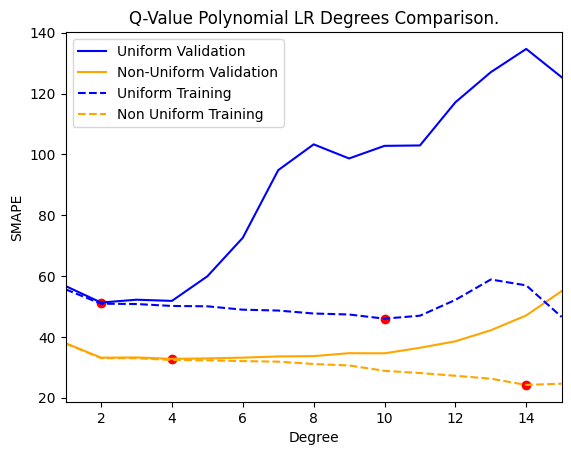

In [64]:
x = range(1,16)

y1 = test_uniform_qvalue
lowest_index_y1 = y1.index(min(y1))

y2 = test_non_uniform_qvalue
lowest_index_y2 = y2.index(min(y2))

y3 = train_uniform_qvalue
lowest_index_y3 = y3.index(min(y3))

y4 = train_non_uniform_qvalue
lowest_index_y4 = y4.index(min(y4))

fig, ax = plt.subplots()

ax.plot(x, y1, label='Uniform Validation', color = "blue")
ax.plot(x, y2, label='Non-Uniform Validation', color = "orange")
ax.plot(x, y3, label='Uniform Training', color = "blue", linestyle='--')
ax.plot(x, y4, label='Non Uniform Training', color = "orange", linestyle='--')

ax.scatter(x[lowest_index_y1], y1[lowest_index_y1], color='red')
ax.scatter(x[lowest_index_y2], y2[lowest_index_y2], color='red')
ax.scatter(x[lowest_index_y3], y3[lowest_index_y3], color='red')
ax.scatter(x[lowest_index_y4], y4[lowest_index_y4], color='red')

           
ax.set_xlabel('Degree')
ax.set_ylabel("SMAPE")
ax.set_title('Q-Value Polynomial LR Degrees Comparison.')

ax.legend()
ax.set_xlim(1, 15)

plt.show()

### Testing Accuracy: Uniform Q value approximation

In [27]:
X = df_uni[['Player','Pit', 'Goal', 'Wall']]
y = df_uni[['Q_Current']]

In [30]:
testing_accur_uniform_q_value = []

for degree in degree_range:
    print(f'degree {degree}:')
    
    poly = PolynomialFeatures(degree=degree)
    X_poly_train = poly.fit_transform(X)

    poly_model = LinearRegression()
    poly_model.fit(X_poly_train, y.values.ravel())
    
    
    win_num = 0
    for i in range(0,10):
        max_games = 1000
        wins = 0
        for i in range(max_games):
            win = gridworld_plr_test_model(poly_model, degree, 'random', display = False)
            if win:
                wins += 1
        win_perc = float(wins) / float(max_games)
        win_num = win_num + win_perc
    win_num = win_num / 10
    testing_accur_uniform_q_value.append(win_num*100)
    print("Win percentage: {}%".format(win_num*100))

degree 1:
Win percentage: 20.290000000000003%
degree 2:
Win percentage: 42.470000000000006%
degree 3:
Win percentage: 41.19%
degree 4:
Win percentage: 49.320000000000014%
degree 5:
Win percentage: 46.16%
degree 6:
Win percentage: 51.66000000000002%
degree 7:
Win percentage: 51.64%
degree 8:
Win percentage: 52.39%
degree 9:
Win percentage: 52.77%
degree 10:
Win percentage: 57.550000000000004%
degree 11:
Win percentage: 58.24%
degree 12:
Win percentage: 52.760000000000005%
degree 13:
Win percentage: 44.33%
degree 14:
Win percentage: 47.51999999999999%
degree 15:
Win percentage: 55.62999999999999%


### Testing Accuracy: Non Uniform Q value approximation

In [31]:
X = df_non_uni[['Player','Pit', 'Goal', 'Wall']]
y = df_non_uni[['Q_Current']]

In [32]:
testing_accur_non_uniform_q_value = []

for degree in degree_range:
    print(f'degree {degree}:')
    
    poly = PolynomialFeatures(degree=degree)
    X_poly_train = poly.fit_transform(X)

    poly_model = LinearRegression()
    poly_model.fit(X_poly_train, y.values.ravel())
    
    
    win_num = 0
    for i in range(0,10):
        max_games = 1000
        wins = 0
        for i in range(max_games):
            win = gridworld_plr_test_model(poly_model, degree, 'random', display = False)
            if win:
                wins += 1
        win_perc = float(wins) / float(max_games)
        win_num = win_num + win_perc
    win_num = win_num / 10
    testing_accur_non_uniform_q_value.append(win_num*100)
    print("Win percentage: {}%".format(win_num*100))

degree 1:
Win percentage: 19.610000000000003%
degree 2:
Win percentage: 69.71000000000001%
degree 3:
Win percentage: 66.97%
degree 4:
Win percentage: 59.24999999999999%
degree 5:
Win percentage: 57.38999999999999%
degree 6:
Win percentage: 47.440000000000005%
degree 7:
Win percentage: 46.80000000000001%
degree 8:
Win percentage: 38.62%
degree 9:
Win percentage: 40.38%
degree 10:
Win percentage: 43.199999999999996%
degree 11:
Win percentage: 41.18000000000001%
degree 12:
Win percentage: 40.66%
degree 13:
Win percentage: 35.0%
degree 14:
Win percentage: 25.900000000000002%
degree 15:
Win percentage: 24.67%


### Testing Accuracy: Visualization for Q - value approximation

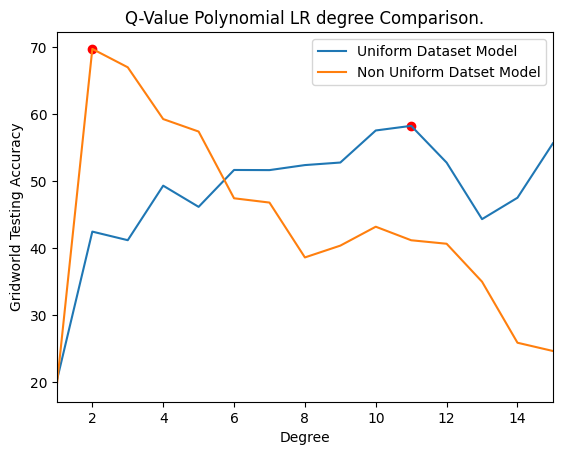

In [33]:
x = range(1,16)

y1 = testing_accur_uniform_q_value
max_index_y1 = y1.index(max(y1))

y2 = testing_accur_non_uniform_q_value
max_index_y2 = y2.index(max(y2))

fig, ax = plt.subplots()

ax.plot(x, y1, label='Uniform Dataset Model')
ax.plot(x, y2, label='Non Uniform Datset Model')

ax.scatter(x[max_index_y1], y1[max_index_y1], color='red')
ax.scatter(x[max_index_y2], y2[max_index_y2], color='red')

ax.set_xlabel('Degree')
ax.set_ylabel("Gridworld Testing Accuracy")
ax.set_title('Q-Value Polynomial LR degree Comparison.')

ax.legend()

ax.set_xlim(1, 15)

plt.show()

### SMAPE: Uniform Bellman Operator approximation

In [34]:
X = df_uni[['Player','Pit', 'Goal', 'Wall']]
y = df_uni[['Bellman_Operator']]

In [35]:
degree_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15] 

train_uniform_bo = []

test_uniform_bo = []

for degree in degree_range:
    print(f'degree {degree}:')
    
    poly = PolynomialFeatures(degree=degree)
    X_poly_train = poly.fit_transform(X)

    poly_model = LinearRegression()

    scores = cross_validate(poly_model, X_poly_train, y.values.ravel(), scoring=score, cv=5, return_train_score=True)
    
    # train set results
    r2_train = scores['train_score']
    train_uniform_bo.append(np.mean(r2_train))
    # test set results
    r2_test = scores['test_score']   
    test_uniform_bo.append(np.mean(r2_test))

    print('Average Validation SMAPE:', np.mean(r2_test))
    print('Average Train SMAPE:', np.mean(r2_train))
    
    print('\n\n')

degree 1:
Average Validation SMAPE: 50.269999999999996
Average Train SMAPE: 50.15



degree 2:
Average Validation SMAPE: 44.596000000000004
Average Train SMAPE: 44.494



degree 3:
Average Validation SMAPE: 44.89399999999999
Average Train SMAPE: 44.38



degree 4:
Average Validation SMAPE: 43.012
Average Train SMAPE: 41.525999999999996



degree 5:
Average Validation SMAPE: 46.89
Average Train SMAPE: 41.480000000000004



degree 6:
Average Validation SMAPE: 59.908
Average Train SMAPE: 39.864



degree 7:
Average Validation SMAPE: 81.68199999999999
Average Train SMAPE: 39.738



degree 8:
Average Validation SMAPE: 88.332
Average Train SMAPE: 39.233999999999995



degree 9:
Average Validation SMAPE: 88.03
Average Train SMAPE: 39.128



degree 10:
Average Validation SMAPE: 90.90599999999999
Average Train SMAPE: 37.798



degree 11:
Average Validation SMAPE: 97.66600000000001
Average Train SMAPE: 39.364



degree 12:
Average Validation SMAPE: 124.11399999999999
Average Train SMAPE: 57.5539

### SMAPE: Non Uniform Bellman Operator approximation

In [36]:
X = df_non_uni[['Player','Pit', 'Goal', 'Wall']]
y = df_non_uni[['Bellman_Operator']]

In [37]:
train_non_uniform_bo = []

test_non_uniform_bo = []

for degree in degree_range:
    print(f'degree {degree}:')
    
    poly = PolynomialFeatures(degree=degree)
    X_poly_train = poly.fit_transform(X)

    poly_model = LinearRegression()

    scores = cross_validate(poly_model, X_poly_train, y.values.ravel(), scoring=score, cv=5, return_train_score=True)
    
    # train set results
    r2_train = scores['train_score']
    train_non_uniform_bo.append(np.mean(r2_train))
    # test set results
    r2_test = scores['test_score']   
    test_non_uniform_bo.append(np.mean(r2_test))

    print('Average Validation SMAPE:', np.mean(r2_test))
    print('Average Train SMAPE:', np.mean(r2_train))
    
    print('\n\n')

degree 1:
Average Validation SMAPE: 41.852000000000004
Average Train SMAPE: 41.751999999999995



degree 2:
Average Validation SMAPE: 38.814
Average Train SMAPE: 38.64



degree 3:
Average Validation SMAPE: 38.898
Average Train SMAPE: 38.646



degree 4:
Average Validation SMAPE: 37.162
Average Train SMAPE: 36.864



degree 5:
Average Validation SMAPE: 37.946000000000005
Average Train SMAPE: 37.202



degree 6:
Average Validation SMAPE: 38.152
Average Train SMAPE: 36.940000000000005



degree 7:
Average Validation SMAPE: 39.086
Average Train SMAPE: 37.008



degree 8:
Average Validation SMAPE: 39.804
Average Train SMAPE: 36.664



degree 9:
Average Validation SMAPE: 41.252
Average Train SMAPE: 36.596000000000004



degree 10:
Average Validation SMAPE: 41.717999999999996
Average Train SMAPE: 34.71



degree 11:
Average Validation SMAPE: 44.884
Average Train SMAPE: 34.721999999999994



degree 12:
Average Validation SMAPE: 47.396
Average Train SMAPE: 34.448



degree 13:
Average Validati

### SMAPE: Visualization for Bellman Operator approximation

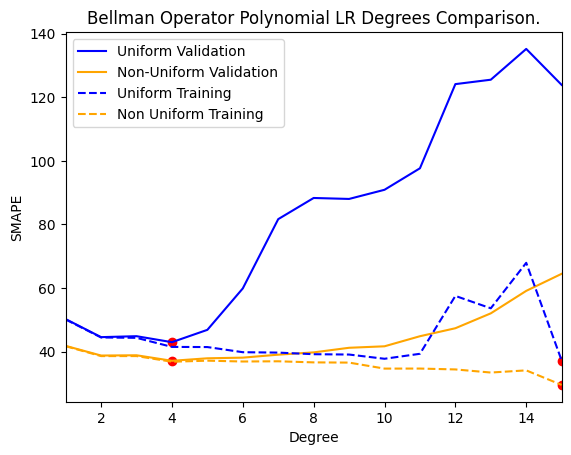

In [38]:
x = range(1,16)

y1 = test_uniform_bo
lowest_index_y1 = y1.index(min(y1))

y2 = test_non_uniform_bo
lowest_index_y2 = y2.index(min(y2))

y3 = train_uniform_bo
lowest_index_y3 = y3.index(min(y3))

y4 = train_non_uniform_bo
lowest_index_y4 = y4.index(min(y4))

fig, ax = plt.subplots()

ax.plot(x, y1, label='Uniform Validation', color = "blue")
ax.plot(x, y2, label='Non-Uniform Validation', color = "orange")
ax.plot(x, y3, label='Uniform Training', color = "blue", linestyle='--')
ax.plot(x, y4, label='Non Uniform Training', color = "orange", linestyle='--')

ax.scatter(x[lowest_index_y1], y1[lowest_index_y1], color='red')
ax.scatter(x[lowest_index_y2], y2[lowest_index_y2], color='red')
ax.scatter(x[lowest_index_y3], y3[lowest_index_y3], color='red')
ax.scatter(x[lowest_index_y4], y4[lowest_index_y4], color='red')

           
ax.set_xlabel('Degree')
ax.set_ylabel("SMAPE")
ax.set_title('Bellman Operator Polynomial LR Degrees Comparison.')

ax.legend()
ax.set_xlim(1, 15)

plt.show()

### Testing Accuracy: Uniform Bellman Operator approximation

In [42]:
X = df_uni[['Player','Pit', 'Goal', 'Wall']]
y = df_uni[['Bellman_Operator']]

In [43]:
testing_accur_uniform_bo = []

for degree in degree_range:
    print(f'degree {degree}:')
    
    poly = PolynomialFeatures(degree=degree)
    X_poly_train = poly.fit_transform(X)

    poly_model = LinearRegression()
    poly_model.fit(X_poly_train, y.values.ravel())
    
    
    win_num = 0
    for i in range(0,10):
        max_games = 1000
        wins = 0
        for i in range(max_games):
            win = gridworld_plr_test_model(poly_model, degree, 'random', display = False)
            if win:
                wins += 1
        win_perc = float(wins) / float(max_games)
        win_num = win_num + win_perc
    win_num = win_num / 10
    testing_accur_uniform_bo.append(win_num*100)
    print("Win percentage: {}%".format(win_num*100))

degree 1:
Win percentage: 20.25%
degree 2:
Win percentage: 49.779999999999994%
degree 3:
Win percentage: 50.38%
degree 4:
Win percentage: 64.52999999999999%
degree 5:
Win percentage: 65.14%
degree 6:
Win percentage: 64.83000000000001%
degree 7:
Win percentage: 65.42%
degree 8:
Win percentage: 64.66000000000001%
degree 9:
Win percentage: 65.62%
degree 10:
Win percentage: 56.8%
degree 11:
Win percentage: 56.52%
degree 12:
Win percentage: 49.339999999999996%
degree 13:
Win percentage: 52.56999999999999%
degree 14:
Win percentage: 36.06999999999999%
degree 15:
Win percentage: 62.26999999999999%


### Testing Accuracy: Non-Uniform Bellman Operator approximation

In [44]:
X = df_non_uni[['Player','Pit', 'Goal', 'Wall']]
y = df_non_uni[['Bellman_Operator']]

In [45]:
testing_accur_non_uniform_bo = []

for degree in degree_range:
    print(f'degree {degree}:')
    
    poly = PolynomialFeatures(degree=degree)
    X_poly_train = poly.fit_transform(X)

    poly_model = LinearRegression()
    poly_model.fit(X_poly_train, y.values.ravel())
    
    
    win_num = 0
    for i in range(0,10):
        max_games = 1000
        wins = 0
        for i in range(max_games):
            win = gridworld_plr_test_model(poly_model, degree, 'random', display = False)
            if win:
                wins += 1
        win_perc = float(wins) / float(max_games)
        win_num = win_num + win_perc
    win_num = win_num / 10
    testing_accur_non_uniform_bo.append(win_num*100)
    print("Win percentage: {}%".format(win_num*100))

degree 1:
Win percentage: 20.82%
degree 2:
Win percentage: 60.41%
degree 3:
Win percentage: 64.25%
degree 4:
Win percentage: 64.51%
degree 5:
Win percentage: 64.05000000000001%
degree 6:
Win percentage: 59.74999999999999%
degree 7:
Win percentage: 54.54000000000001%
degree 8:
Win percentage: 45.53999999999999%
degree 9:
Win percentage: 46.550000000000004%
degree 10:
Win percentage: 41.19%
degree 11:
Win percentage: 41.3%
degree 12:
Win percentage: 39.51%
degree 13:
Win percentage: 33.72%
degree 14:
Win percentage: 30.310000000000002%
degree 15:
Win percentage: 31.0%


### Testing Accuracy: Visualization for Bellman Operator approximation

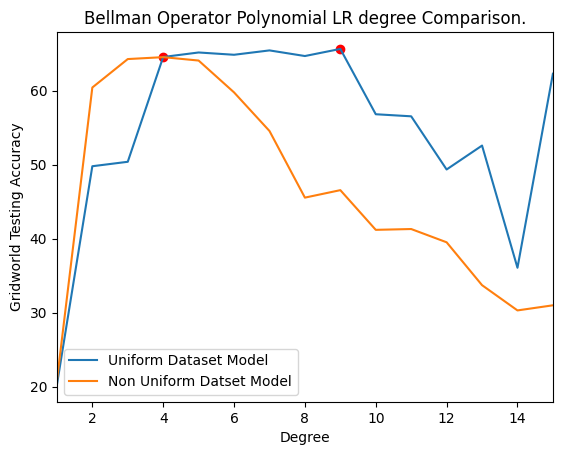

In [46]:
x = range(1,16)

y1 = testing_accur_uniform_bo
max_index_y1 = y1.index(max(y1))

y2 = testing_accur_non_uniform_bo
max_index_y2 = y2.index(max(y2))

fig, ax = plt.subplots()

ax.plot(x, y1, label='Uniform Dataset Model')
ax.plot(x, y2, label='Non Uniform Datset Model')

ax.scatter(x[max_index_y1], y1[max_index_y1], color='red')
ax.scatter(x[max_index_y2], y2[max_index_y2], color='red')

ax.set_xlabel('Degree')
ax.set_ylabel("Gridworld Testing Accuracy")
ax.set_title('Bellman Operator Polynomial LR degree Comparison.')

ax.legend()

ax.set_xlim(1, 15)

plt.show()

## 9. Uniform Dataset Polynomial LR Performance <a id = "plruniform"> 

### Q value approximation

In [27]:
X = df_uni[['Player','Pit', 'Goal', 'Wall']]
y = df_uni[['Q_Current']]

In [32]:
poly = PolynomialFeatures(degree=4)
X_poly_train = poly.fit_transform(X.values)

poly_uniform_q = LinearRegression()
scores = cross_validate(poly_uniform_q, X_poly_train, y.values.ravel(), scoring=score, cv=5, return_train_score=True)
SMAPE_poly_uniform_q = np.mean(scores['test_score'])
SMAPE_poly_uniform_q

51.82000000000001

In [33]:
poly_uniform_q.fit(X_poly_train,y.values.ravel())

LinearRegression()

In [35]:
win_num = 0
for i in range(0,10):
    max_games = 1000
    wins = 0
    for i in range(max_games):
        win = gridworld_plr_test_model(poly_uniform_q, 4, 'random', display = False)
        if win:
            wins += 1
    win_perc = float(wins) / float(max_games)
    win_num = win_num + win_perc
    print("Games played: {0}, # of wins: {1}".format(max_games,wins))
    print(win_perc)
    print(win_num)
win_num = win_num / 10
print("Win percentage: {}%".format(win_num*100))

Games played: 1000, # of wins: 489
0.489
0.489
Games played: 1000, # of wins: 500
0.5
0.989
Games played: 1000, # of wins: 493
0.493
1.482
Games played: 1000, # of wins: 476
0.476
1.958
Games played: 1000, # of wins: 511
0.511
2.469
Games played: 1000, # of wins: 456
0.456
2.925
Games played: 1000, # of wins: 475
0.475
3.4
Games played: 1000, # of wins: 480
0.48
3.88
Games played: 1000, # of wins: 496
0.496
4.3759999999999994
Games played: 1000, # of wins: 496
0.496
4.872
Win percentage: 48.72%


### Bellman Operator Approximation

In [36]:
X = df_uni[['Player','Pit', 'Goal', 'Wall']]
y = df_uni[['Bellman_Operator']]

In [37]:
poly = PolynomialFeatures(degree=4)
X_poly_train = poly.fit_transform(X.values)

poly_uniform_bo = LinearRegression()
scores = cross_validate(poly_uniform_bo, X_poly_train, y.values.ravel(), scoring=score, cv=5, return_train_score=True)
SMAPE_poly_uniform_bo = np.mean(scores['test_score'])
SMAPE_poly_uniform_bo

43.012

In [38]:
poly_uniform_bo.fit(X_poly_train,y.values.ravel())

LinearRegression()

In [39]:
win_num = 0
for i in range(0,10):
    max_games = 1000
    wins = 0
    for i in range(max_games):
        win = gridworld_plr_test_model(poly_uniform_bo, 4, 'random', display = False)
        if win:
            wins += 1
    win_perc = float(wins) / float(max_games)
    win_num = win_num + win_perc
    print("Games played: {0}, # of wins: {1}".format(max_games,wins))
    print(win_perc)
    print(win_num)
win_num = win_num / 10
print("Win percentage: {}%".format(win_num*100))

Games played: 1000, # of wins: 644
0.644
0.644
Games played: 1000, # of wins: 677
0.677
1.3210000000000002
Games played: 1000, # of wins: 697
0.697
2.0180000000000002
Games played: 1000, # of wins: 670
0.67
2.688
Games played: 1000, # of wins: 625
0.625
3.313
Games played: 1000, # of wins: 646
0.646
3.959
Games played: 1000, # of wins: 644
0.644
4.603
Games played: 1000, # of wins: 664
0.664
5.2669999999999995
Games played: 1000, # of wins: 682
0.682
5.949
Games played: 1000, # of wins: 660
0.66
6.609
Win percentage: 66.09%


## 10. Non-Uniform Dataset Polynomial LR Performance <a id = "plrnonuniform"> 

### Q value approximation

In [40]:
X = df_non_uni[['Player','Pit', 'Goal', 'Wall']]
y = df_non_uni[['Q_Current']]

In [41]:
poly = PolynomialFeatures(degree=4)
X_poly_train = poly.fit_transform(X.values)

poly_non_uniform_q = LinearRegression()
scores = cross_validate(poly_non_uniform_q, X_poly_train, y.values.ravel(), scoring=score, cv=5, return_train_score=True)
SMAPE_poly_non_uniform_q = np.mean(scores['test_score'])
SMAPE_poly_non_uniform_q

32.766000000000005

In [42]:
poly_non_uniform_q.fit(X_poly_train,y.values.ravel())

LinearRegression()

In [43]:
win_num = 0
for i in range(0,10):
    max_games = 1000
    wins = 0
    for i in range(max_games):
        win = gridworld_plr_test_model(poly_non_uniform_q, 4, 'random', display = False)
        if win:
            wins += 1
    win_perc = float(wins) / float(max_games)
    win_num = win_num + win_perc
    print("Games played: {0}, # of wins: {1}".format(max_games,wins))
    print(win_perc)
    print(win_num)
win_num = win_num / 10
print("Win percentage: {}%".format(win_num*100))

Games played: 1000, # of wins: 576
0.576
0.576
Games played: 1000, # of wins: 573
0.573
1.149
Games played: 1000, # of wins: 570
0.57
1.7189999999999999
Games played: 1000, # of wins: 596
0.596
2.315
Games played: 1000, # of wins: 575
0.575
2.8899999999999997
Games played: 1000, # of wins: 601
0.601
3.4909999999999997
Games played: 1000, # of wins: 596
0.596
4.087
Games played: 1000, # of wins: 604
0.604
4.691
Games played: 1000, # of wins: 578
0.578
5.269
Games played: 1000, # of wins: 588
0.588
5.857
Win percentage: 58.57%


### Bellman Operator Approximation

In [44]:
X = df_non_uni[['Player','Pit', 'Goal', 'Wall']]
y = df_non_uni[['Bellman_Operator']]

In [45]:
poly = PolynomialFeatures(degree=4)
X_poly_train = poly.fit_transform(X.values)

poly_non_uniform_bo = LinearRegression()
scores = cross_validate(poly_non_uniform_bo, X_poly_train, y.values.ravel(), scoring=score, cv=5, return_train_score=True)
SMAPE_poly_non_uniform_bo = np.mean(scores['test_score'])
SMAPE_poly_non_uniform_bo

37.162

In [46]:
poly_non_uniform_bo.fit(X_poly_train,y.values.ravel())

LinearRegression()

In [47]:
win_num = 0
for i in range(0,10):
    max_games = 1000
    wins = 0
    for i in range(max_games):
        win = gridworld_plr_test_model(poly_non_uniform_bo, 4, 'random', display = False)
        if win:
            wins += 1
    win_perc = float(wins) / float(max_games)
    win_num = win_num + win_perc
    print("Games played: {0}, # of wins: {1}".format(max_games,wins))
    print(win_perc)
    print(win_num)
win_num = win_num / 10
print("Win percentage: {}%".format(win_num*100))

Games played: 1000, # of wins: 627
0.627
0.627
Games played: 1000, # of wins: 644
0.644
1.271
Games played: 1000, # of wins: 625
0.625
1.896
Games played: 1000, # of wins: 659
0.659
2.5549999999999997
Games played: 1000, # of wins: 659
0.659
3.2139999999999995
Games played: 1000, # of wins: 665
0.665
3.8789999999999996
Games played: 1000, # of wins: 638
0.638
4.5169999999999995
Games played: 1000, # of wins: 654
0.654
5.170999999999999
Games played: 1000, # of wins: 646
0.646
5.816999999999999
Games played: 1000, # of wins: 650
0.65
6.467
Win percentage: 64.66999999999999%


## 10. Visuals <a id = "visuals"> 

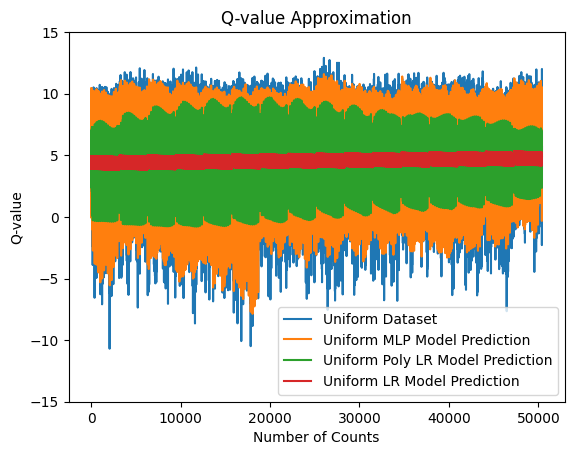

In [83]:
X = df_uni[['Player','Pit', 'Goal', 'Wall']]
y = df_uni[['Q_Current']]
counts =  df_uni[['Unnamed: 0']] 

poly = PolynomialFeatures(degree=4)
poly_features = poly.fit_transform(X.values)
y_pred_poly = poly_uniform_q.predict(poly_features)

y_pred = mlp_uniform_q.predict(X.values)

y_pred_lr = lr_uniform_q.predict(X.values)

plt.plot(counts, y, label='Uniform Dataset')
plt.plot(counts, y_pred, label='Uniform MLP Model Prediction')
plt.plot(counts, y_pred_poly, label= 'Uniform Poly LR Model Prediction')
plt.plot(counts, y_pred_lr, label='Uniform LR Model Prediction')
plt.xlabel('Number of Counts')
plt.ylabel('Q-value')
plt.title('Q-value Approximation')
plt.legend()

plt.ylim(-15, 15)

plt.show()

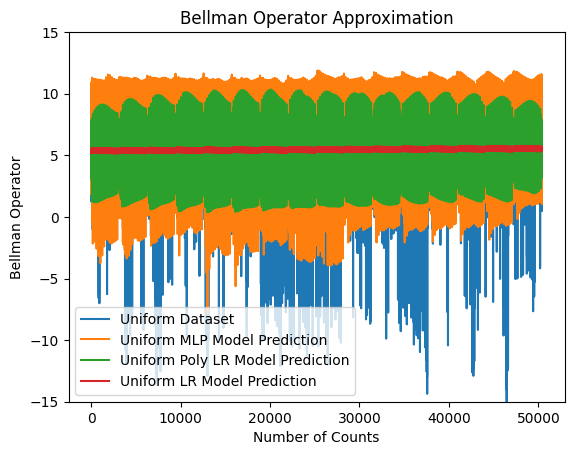

In [82]:
X = df_uni[['Player','Pit', 'Goal', 'Wall']]
y = df_uni[['Bellman_Operator']]
counts =  df_uni[['Unnamed: 0']] 

poly = PolynomialFeatures(degree=4)
poly_features = poly.fit_transform(X.values)
y_pred_poly = poly_uniform_bo.predict(poly_features)

y_pred = mlp_uniform_bo.predict(X.values)

y_pred_lr = lr_uniform_bo.predict(X.values)

plt.plot(counts, y, label='Uniform Dataset')
plt.plot(counts, y_pred, label='Uniform MLP Model Prediction')
plt.plot(counts, y_pred_poly, label= 'Uniform Poly LR Model Prediction')
plt.plot(counts, y_pred_lr, label='Uniform LR Model Prediction')
plt.xlabel('Number of Counts')
plt.ylabel('Bellman Operator')
plt.title('Bellman Operator Approximation')
plt.legend()

plt.ylim(-15, 15)

plt.show()

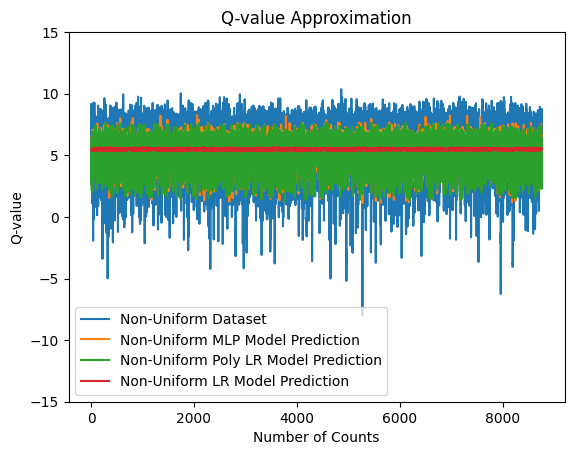

In [81]:
X = df_non_uni[['Player','Pit', 'Goal', 'Wall']]
y = df_non_uni[['Q_Current']]
counts =  df_non_uni[['Unnamed: 0']] 

poly = PolynomialFeatures(degree=4)
poly_features = poly.fit_transform(X.values)
y_pred_poly = poly_non_uniform_q.predict(poly_features)

y_pred = mlp_non_uniform_q.predict(X.values)

y_pred_lr = lr_non_uniform_q.predict(X.values)

plt.plot(counts, y, label='Non-Uniform Dataset')
plt.plot(counts, y_pred, label='Non-Uniform MLP Model Prediction')
plt.plot(counts, y_pred_poly, label= 'Non-Uniform Poly LR Model Prediction')
plt.plot(counts, y_pred_lr, label='Non-Uniform LR Model Prediction')
plt.xlabel('Number of Counts')
plt.ylabel('Q-value')
plt.title('Q-value Approximation')
plt.legend()

plt.ylim(-15, 15)

plt.show()

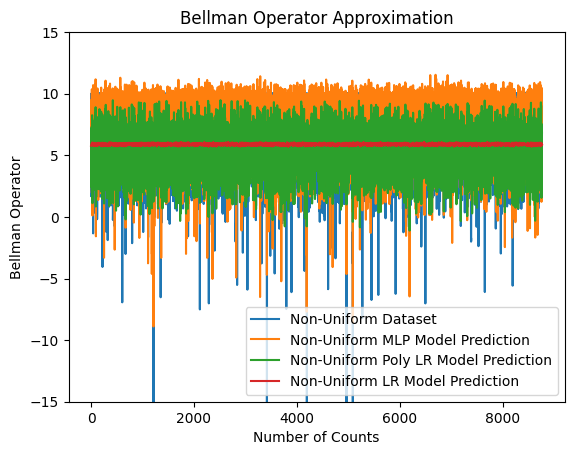

In [80]:
X = df_non_uni[['Player','Pit', 'Goal', 'Wall']]
y = df_non_uni[['Bellman_Operator']]
counts =  df_non_uni[['Unnamed: 0']] 

poly = PolynomialFeatures(degree=4)
poly_features = poly.fit_transform(X.values)
y_pred_poly = poly_non_uniform_bo.predict(poly_features)

y_pred = mlp_non_uniform_bo.predict(X.values)

y_pred_lr = lr_non_uniform_bo.predict(X.values)

plt.plot(counts, y, label='Non-Uniform Dataset')
plt.plot(counts, y_pred, label='Non-Uniform MLP Model Prediction')
plt.plot(counts, y_pred_poly, label= 'Non-Uniform Poly LR Model Prediction')
plt.plot(counts, y_pred_lr, label='Non-Uniform LR Model Prediction')
plt.xlabel('Number of Counts')
plt.ylabel('Bellman Operator')
plt.title('Bellman Operator Approximation')
plt.legend()

plt.ylim(-15, 15)

plt.show()